## Install Tensortrade

In [36]:
#!pip install git+https://github.com/kodiakcrypto/tensortrade.git#egg=tensortrade[data1]
#!pip install git+https://github.com/kodiakcrypto/tensortrade.git#egg=tensortrade[data2]

In [37]:
#!pip install ta newtulipy

In [38]:
import tulipy as _ta
import ta

## Get TA Data Columns

In [39]:
def XcrossY(candles, sma, sma_length):
    arr = []
    for i in range(len(sma) -1 ):
        if i <= sma_length: arr.append(0)
        else:
            if candles['high'].iloc[i-1] <= sma[i-1] and candles['high'].iloc[i] > sma[i]:
                arr.append(1)
            elif candles['low'].iloc[i-1] >= sma[i-1] and candles['low'].iloc[i] < sma[i]:
                arr.append(-1)
            else:
                arr.append(0)
    return arr

def slopeOfSeries(values, lookback):
    """get rise over run"""
    arr = []
    for i in range(len(values)-1):
        if i <= lookback: arr.append(0)
        else:
            slope = (values[i] - values[i-lookback]) / lookback
            if   slope > 0: arr.append(1)
            elif slope < 0: arr.append(-1)
            else:           arr.append(0)
    return arr

def checkForConsecutiveCandles(candles):
    """ 3 green and not 4"""
    arr = []
    for i in range(len(candles)-1):
        if i <= 3: arr.append(0)
        else:
            if (candles['close'].iloc[i] > candles['open'].iloc[i] and
                candles['close'].iloc[i-1] > candles['open'].iloc[i-1] and
                candles['close'].iloc[i-2] > candles['open'].iloc[i-2] and
                candles['close'].iloc[i-3] <= candles['open'].iloc[i-3]):
                arr.append(1)
            #3 red not 4
            elif (candles['close'].iloc[i] < candles['open'].iloc[i] and
                candles['close'].iloc[i-1] < candles['open'].iloc[i-1] and
                candles['close'].iloc[i-2] < candles['open'].iloc[i-2] and
                candles['close'].iloc[i-3] >= candles['open'].iloc[i-3]):
                arr.append(-1)
            else:
                arr.append(0)
    return arr

def getBBvsPrice(close_array, candles, stddev):
    arr = []
    period=20
    (bbands_lower, _, bbands_upper) = _ta.bbands(close_array, period=period, stddev=stddev)
    for i in range(len(bbands_upper)-1):
        if i <= period:
            arr.append(0)
        if candles['high'].iloc[i] > bbands_upper[i] and candles['low'].iloc[i] < bbands_lower[i]:
            arr.append(0)
        elif candles['high'].iloc[i] > bbands_upper[i]:
            arr.append(1)
        elif candles['low'].iloc[i] < bbands_lower[i]:
            arr.append(-1)
        else:
            arr.append(0)
    return arr

def getSMACrosses(sma_fast, sma_slow):
    arr = []
    for i in range(len(sma_slow)-2):
        if sma_fast[i] <= sma_slow[i] and sma_fast[i+1] > sma_slow[i+1]:
            arr.append(1)
        elif sma_fast[i] >= sma_slow[i] and sma_fast[i+1] < sma_slow[i+1]:
            arr.append(-1)
        else:
            arr.append(0)
    return arr

def sauceCity(candles, date_col_name='date',
                       open_col_name='open',
                       high_col_name='high',
                       low_col_name='low',
                       close_col_name='close'):
    lookback          = 20
    fast_sma_length   = 36
    slow_sma_length   = 85
    filter_sma_length = 200

    timestamps = candles[date_col_name].to_numpy()
    close_array = candles[close_col_name].to_numpy()

    # BBANDS
    price_vs_bbands_2x = getBBvsPrice(close_array, candles, stddev=2)
    price_vs_bbands_3x = getBBvsPrice(close_array, candles, stddev=3)

    # Get price vs SMAs and SMA crosses
    sma_fast = _ta.sma(close_array, period=fast_sma_length)
    sma_slow = _ta.sma(close_array, period=slow_sma_length)
    price_vs_fastSMA = XcrossY(candles, sma_fast, fast_sma_length)
    price_vs_slowSMA = XcrossY(candles, sma_slow, slow_sma_length)
    sma_crosses = getSMACrosses(sma_fast, sma_slow)

    # get SMA 200 vals + slope
    sma_filter = _ta.sma(close_array, filter_sma_length)
    sma_filter_slope = slopeOfSeries(sma_filter, lookback)
    price_vs_filterSMA = XcrossY(candles, sma_filter, filter_sma_length)

    # check for 3 consecutive same color candles
    consecutive_candles = checkForConsecutiveCandles(candles)

    #trendline crosses
    #lookbacks

    print(
        len(timestamps),
        len(price_vs_bbands_2x),
        len(price_vs_bbands_3x),
        len(price_vs_fastSMA),
        len(price_vs_slowSMA),
        len(sma_crosses),
        len(sma_filter_slope),
        len(price_vs_filterSMA),
        len(consecutive_candles)
    )

    copy_arr = [price_vs_bbands_2x.copy(),price_vs_bbands_3x.copy(),
                price_vs_fastSMA.copy(),price_vs_slowSMA.copy(),sma_crosses.copy(),
                sma_filter_slope.copy(),price_vs_filterSMA.copy(),consecutive_candles.copy()]

    for i in range(len(copy_arr)):
        while len(copy_arr[i]) != len(timestamps):
            if len(copy_arr[i]) < len(timestamps):
                copy_arr[i] = np.insert(copy_arr[i], 0, 0)
            elif len(copy_arr[i]) > len(timestamps):
                copy_arr[i] = copy_arr[i][1:]

    price_vs_bbands_2x = copy_arr[0]
    price_vs_bbands_3x = copy_arr[1]
    price_vs_fastSMA = copy_arr[2]
    price_vs_slowSMA = copy_arr[3]
    sma_crosses = copy_arr[4]
    sma_filter_slope = copy_arr[5]
    price_vs_filterSMA = copy_arr[6]
    consecutive_candles = copy_arr[7]

    print(
        len(timestamps),
        len(price_vs_bbands_2x),
        len(price_vs_bbands_3x),
        len(price_vs_fastSMA),
        len(price_vs_slowSMA),
        len(sma_crosses),
        len(sma_filter_slope),
        len(price_vs_filterSMA),
        len(consecutive_candles)
    )
    all_data = list(zip(
        timestamps,
        price_vs_bbands_2x,price_vs_bbands_3x,
        price_vs_fastSMA,price_vs_slowSMA,sma_crosses,
        sma_filter_slope,price_vs_filterSMA,consecutive_candles,
    ))

    all_data = pd.DataFrame(all_data, columns=[
        'date','price_vs_bbands_2x','price_vs_bbands_3x',
        'price_vs_fastSMA','price_vs_slowSMA','sma_crosses',
        'sma_filter_slope','price_vs_filterSMA','consecutive_candles'])

    return all_data

## Import Needed Tensortrade modules

In [40]:
# À installer si ce n’est pas encore fait :
# !pip install git+https://github.com/kodiakcrypto/tensortrade.git#egg=tensortrade[data]

from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.services.execution.simulated import execute_order

from tensortrade.feed.core import Stream, DataFeed  # ✅ Pas besoin de Module

from tensortrade.env.default import create as create_environment
#from tensortrade.env.default.render import PlotlyTradingChart

from tensortrade.agents import DQNAgent


## Fetch Candle data

In [41]:
import ccxt
import pandas as pd

# Paramètres
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'

# Télécharger les bougies OHLCV
ohlcv = exchange.fetch_ohlcv(symbol=symbol, timeframe=timeframe)

# Construire un DataFrame
df_BTC = pd.DataFrame(ohlcv, columns=["Date", "BTC:open", "BTC:high", "BTC:low", "BTC:close", "BTC:volume"])

# Convertir l'horodatage en datetime
df_BTC["Date"] = pd.to_datetime(df_BTC["Date"], unit="ms")

# Fixer la colonne Date comme index (facultatif)
df_BTC.set_index("Date", inplace=False).head()


,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume
Date,,,,,
2024-01-18,42776.09,42930.00,40683.28,41327.50,43907.51641
2024-01-19,41327.51,42196.86,40280.00,41659.03,48342.74559
2024-01-20,41659.03,41872.56,41456.30,41696.04,15923.99493
2024-01-21,41696.05,41881.39,41500.98,41580.33,11730.16301
2024-01-22,41580.32,41689.65,39431.58,39568.02,55426.19911


In [42]:
import ccxt
import pandas as pd

exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'

# Téléchargement brut via CCXT
ohlcv = exchange.fetch_ohlcv(symbol=symbol, timeframe=timeframe)

# Conversion en DataFrame
df = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)

df.head()

,open,high,low,close,volume
timestamp,,,,,
2024-01-18,42776.09,42930.00,40683.28,41327.50,43907.51641
2024-01-19,41327.51,42196.86,40280.00,41659.03,48342.74559
2024-01-20,41659.03,41872.56,41456.30,41696.04,15923.99493
2024-01-21,41696.05,41881.39,41500.98,41580.33,11730.16301
2024-01-22,41580.32,41689.65,39431.58,39568.02,55426.19911


## Get Ta Vals

In [43]:
#OHCLV dataframe for plotly chart w.o indicators
ohlcv_df = df_BTC.reset_index().rename({"Date": "datetime"}, axis='columns')

In [44]:
import numpy as np

ta_df = df.copy()

# Ne renommer que les colonnes qui contiennent ":" (comme "BTC:close")
ta_df.columns = [
    name.lower().split(':')[1] if ':' in name else name.lower()
    for name in ta_df.columns
]

# Assurez-vous que "Date" est renommé en "date" (utile pour certains modules)
ta_df = df_BTC.reset_index().rename(columns={"Date": "date"})

ta_df['close'] = df_BTC['BTC:close'].to_numpy()
ta_df['open_minus_close'] = np.log(df['open']) - np.log(df['close'])
ta_df['high_minus_low'] = np.log(df['high']) - np.log(df['low'])

ta_df = ta_df.set_index('date')
ta_df

,index,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume,close,open_minus_close,high_minus_low
date,,,,,,,,,
2024-01-18,0,42776.09,42930.00,40683.28,41327.50,43907.51641,41327.50,NaN,NaN
2024-01-19,1,41327.51,42196.86,40280.00,41659.03,48342.74559,41659.03,NaN,NaN
2024-01-20,2,41659.03,41872.56,41456.30,41696.04,15923.99493,41696.04,NaN,NaN
2024-01-21,3,41696.05,41881.39,41500.98,41580.33,11730.16301,41580.33,NaN,NaN
2024-01-22,4,41580.32,41689.65,39431.58,39568.02,55426.19911,39568.02,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-05-27,495,109434.78,110718.00,107516.57,108938.17,21276.65635,108938.17,NaN,NaN
2025-05-28,496,108938.17,109284.70,106769.43,107781.78,15633.78829,107781.78,NaN,NaN
2025-05-29,497,107781.78,108891.91,105322.86,105589.75,19834.70116,105589.75,NaN,NaN


In [45]:
df = ta_df

df.head()

,index,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume,close,open_minus_close,high_minus_low
date,,,,,,,,,
2024-01-18,0,42776.09,42930.00,40683.28,41327.50,43907.51641,41327.50,NaN,NaN
2024-01-19,1,41327.51,42196.86,40280.00,41659.03,48342.74559,41659.03,NaN,NaN
2024-01-20,2,41659.03,41872.56,41456.30,41696.04,15923.99493,41696.04,NaN,NaN
2024-01-21,3,41696.05,41881.39,41500.98,41580.33,11730.16301,41580.33,NaN,NaN
2024-01-22,4,41580.32,41689.65,39431.58,39568.02,55426.19911,39568.02,NaN,NaN


In [46]:

df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['BTC:volume']).on_balance_volume()
df['atr'] = ta.volatility.AverageTrueRange(df['BTC:high'], df['BTC:low'], df['close']).average_true_range()
df['bb_upper_cross'] = ta.volatility.BollingerBands(df['close']).bollinger_hband_indicator()
df['bb_lower_cross'] = ta.volatility.BollingerBands(df['close']).bollinger_lband_indicator()
df['macd'] = ta.trend.MACD(df['close']).macd()
df['macd_signal'] = ta.trend.MACD(df['close']).macd_signal()



In [47]:
# MACD > or < 0.0
i = 0
test = []
for y in df.macd.values:
    if y > 0.0:
        if df.macd_signal.values[i] > 0.0 or i != 0:
            test.append(1)
        else:
            test.append(test[-1])
    elif y < 0.0:
        if df.macd_signal.values[i] < 0.0 or i != 0:
            test.append(-1)
        else:
            test.append(test[-1])
    i += 1


In [48]:
df['macd_above_zero'] = pd.Series(test)
df['pre_macd_above_zero'] = df['macd_above_zero'].shift(1)
df['macd_cross_zero'] = np.where(df['macd_above_zero'] == df['pre_macd_above_zero'], 0, 1)

df = df.drop(['macd', 'macd_signal', 'pre_macd_above_zero', 'macd_above_zero'], axis=1)

df.loc['macd_cross_zero', 0] = 0



In [49]:
df.columns

Index([           'index',         'BTC:open',         'BTC:high',
                'BTC:low',        'BTC:close',       'BTC:volume',
                  'close', 'open_minus_close',   'high_minus_low',
                    'obv',              'atr',   'bb_upper_cross',
         'bb_lower_cross',  'macd_cross_zero',                  0],
      dtype='object')

In [50]:
#df = df.set_index("date")

In [51]:
# Nettoyer le symbole selon les formats possibles
if "_" in symbol:
    base, quote = symbol.split("_")
elif "/" in symbol:
    base, quote = symbol.split("/")
else:
    # format Binance sans séparateur : BTCUSDT → BTC + USDT
    base, quote = symbol[:3], symbol[3:]  # suppose 3+3, ajuster si besoin


## Feature correlation analysis



### Create correlation matrix


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

### Display correlation heatmap

/root/miniconda3/envs/TimeSeries_Clone_DQN/lib/python3.12/site-packages/ta/volume.py:290: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self._vpt = (self._close.pct_change() * self._volume).cumsum()
/root/miniconda3/envs/TimeSeries_Clone_DQN/lib/python3.12/site-packages/ta/volume.py:327: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_change = self._close.pct_change()
/root/miniconda3/envs/TimeSeries_Clone_DQN/lib/python3.12/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

<Axes: >

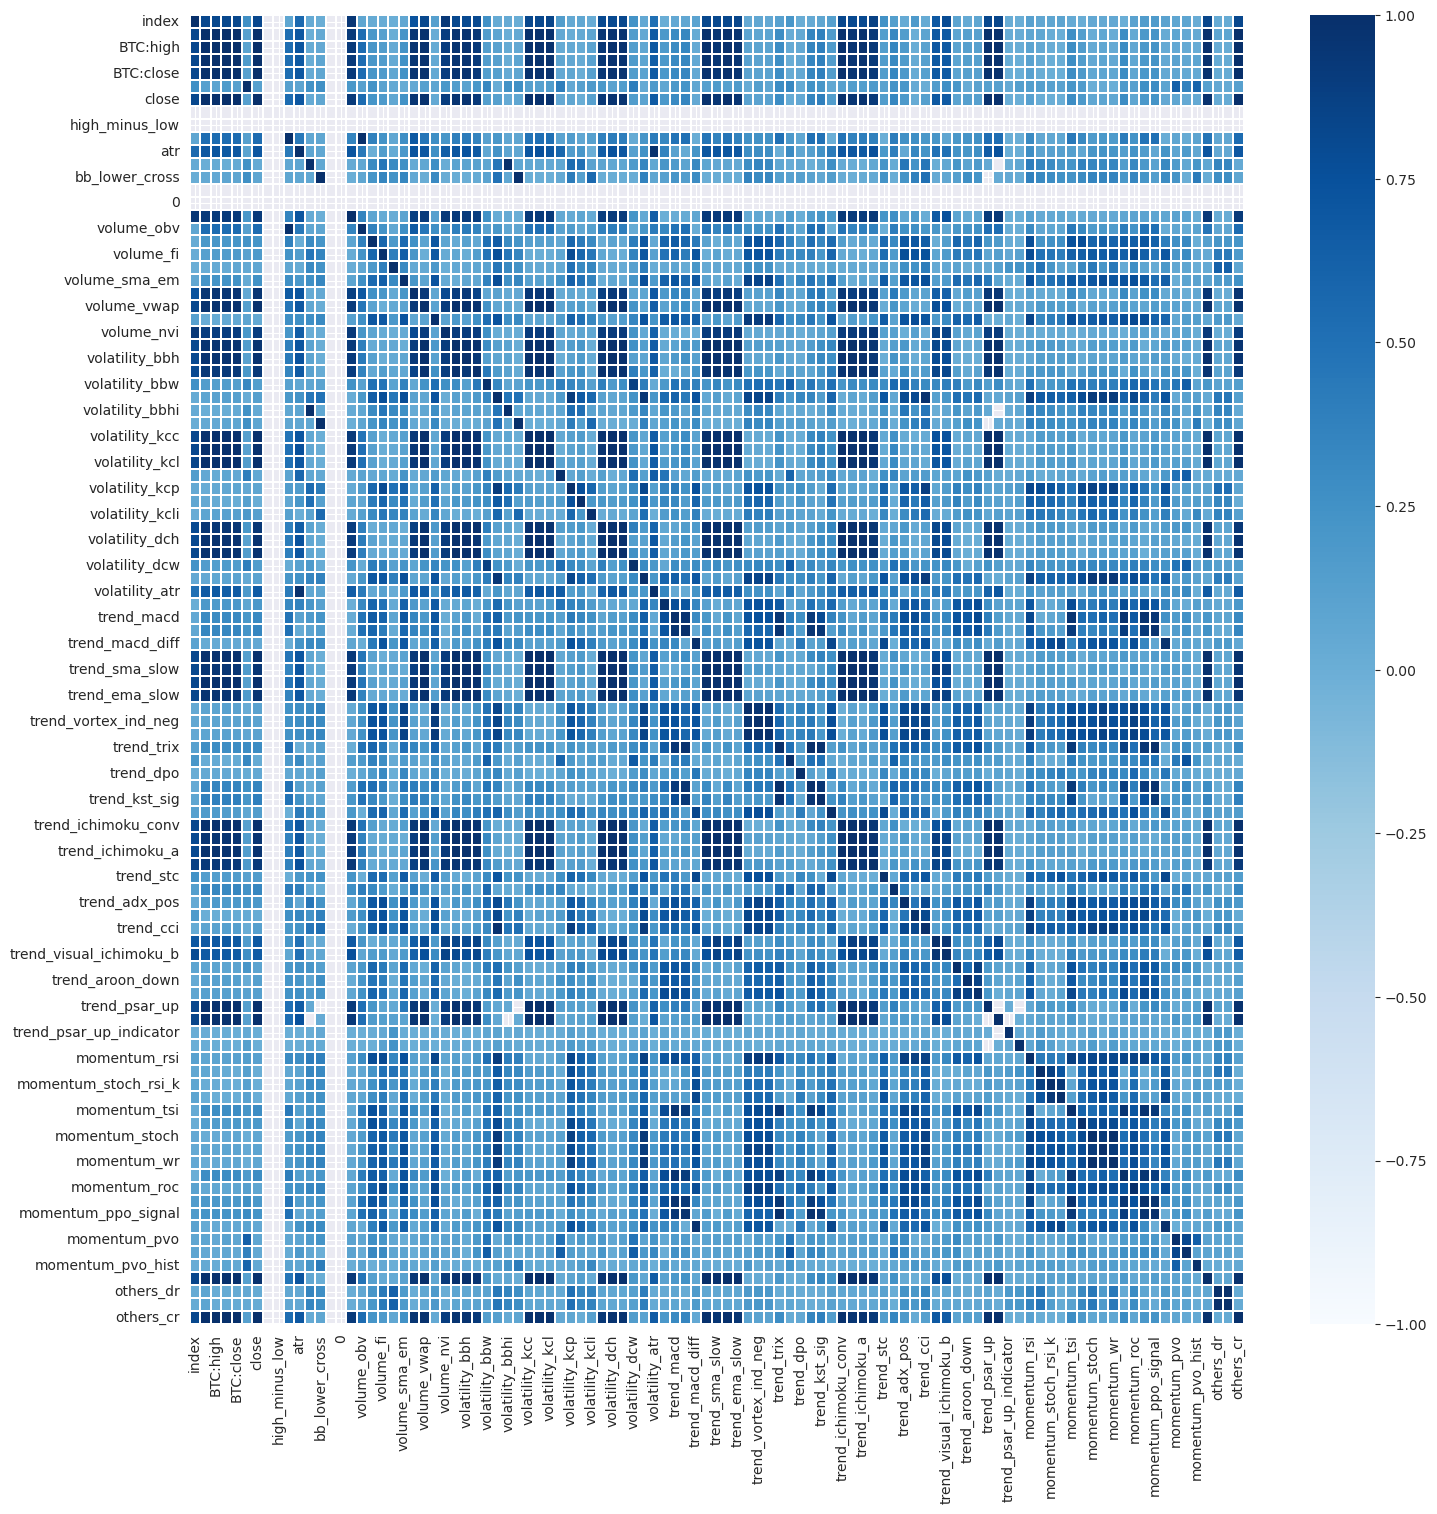

In [53]:
plt.figure(figsize=(17,17))
corr_matrix = ta.add_all_ta_features(df, 'BTC:open', 'BTC:high', 'BTC:low', 'BTC:close', 'BTC:volume').corr().abs()
sns.heatmap(corr_matrix, annot=False, linewidth=0.3, center=0, cmap='Blues', vmin=-1)

In [54]:
corr_matrix

,index,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume,close,open_minus_close,high_minus_low,obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
index,1.000000,0.825289,0.823815,0.828016,0.825180,0.261226,0.825180,NaN,NaN,0.071090,...,0.161169,0.164182,0.107613,0.071172,0.080900,0.016071,0.835750,0.029123,0.027824,0.825180
BTC:open,0.825289,1.000000,0.996697,0.996245,0.993634,0.124242,0.993634,NaN,NaN,0.529424,...,0.183609,0.227877,0.030744,0.081752,0.053201,0.043912,0.987320,0.084272,0.083169,0.993634
BTC:high,0.823815,0.996697,1.000000,0.995011,0.997515,0.089959,0.997515,NaN,NaN,0.534316,...,0.188495,0.232105,0.036386,0.052902,0.032377,0.020045,0.986359,0.020703,0.020380,0.997515
BTC:low,0.828016,0.996245,0.995011,1.000000,0.996550,0.170663,0.996550,NaN,NaN,0.530913,...,0.190060,0.227421,0.053783,0.107581,0.062352,0.078739,0.983426,0.026931,0.024815,0.996550
BTC:close,0.825180,0.993634,0.997515,0.996550,1.000000,0.120224,1.000000,NaN,NaN,0.537652,...,0.194066,0.232653,0.051909,0.072154,0.042602,0.041568,0.983624,0.026271,0.027452,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
momentum_pvo_hist,0.016071,0.043912,0.020045,0.078739,0.041568,0.597330,0.041568,NaN,NaN,0.086544,...,0.049939,0.035431,0.058236,0.631987,0.088028,1.000000,0.031020,0.019880,0.011541,0.041568
momentum_kama,0.835750,0.987320,0.986359,0.983426,0.983624,0.127045,0.983624,NaN,NaN,0.464063,...,0.078183,0.141414,0.060573,0.094178,0.078132,0.031020,1.000000,0.061382,0.060348,0.983624
others_dr,0.029123,0.084272,0.020703,0.026931,0.026271,0.047827,0.026271,NaN,NaN,0.062267,...,0.082460,0.035011,0.167619,0.088209,0.094810,0.019880,0.061382,1.000000,0.999663,0.026271
others_dlr,0.027824,0.083169,0.020380,0.024815,0.027452,0.034162,0.027452,NaN,NaN,0.062389,...,0.082973,0.034424,0.170826,0.079994,0.090084,0.011541,0.060348,0.999663,1.000000,0.027452


### Identify Highly Correlated Features

In [55]:
import numpy as np

#apply log diff pricing to OHLC columns
for column in ['BTC:open','BTC:high','BTC:low','BTC:close']:
  if column in df.columns:
      df[column] = np.log(df[column]).diff()

print(df) # Before dropping columns for comparison

# Slice upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find column names of features with correlation greater than 0.95
# < 0.0 gets rid of data that has negative value despite .abs()
essential_suffixes = ['open', 'high', 'low', 'close']
to_drop = []

for column in upper.columns:
    if isinstance(column, str):
        keep = any(column.lower().endswith(suffix) for suffix in essential_suffixes)
        if not keep and (upper[column] > 0.95).any():
            to_drop.append(column)


# Drop those columns
#df = df.drop(df[to_drop], axis=1)
#print(df)

# Idea
# Add in MA's of the rejected types with new periods and correlate again
# TA_Features.add_moving_avgs(indicators: list = 'all'):
#    list of MA funcs = []
# for func in MA_func_list:
#    func(data['BTC:close'])


                     index  BTC:open  BTC:high   BTC:low  BTC:close  \
date                                                                  
2024-01-18 00:00:00    0.0       NaN       NaN       NaN        NaN   
2024-01-19 00:00:00    1.0 -0.034451 -0.017225 -0.009962   0.007990   
2024-01-20 00:00:00    2.0  0.007990 -0.007715  0.028785   0.000888   
2024-01-21 00:00:00    3.0  0.000888  0.000211  0.001077  -0.002779   
2024-01-22 00:00:00    4.0 -0.002779 -0.004589 -0.051150  -0.049606   
...                    ...       ...       ...       ...        ...   
2025-05-28 00:00:00  496.0 -0.004548 -0.013030 -0.006973  -0.010672   
2025-05-29 00:00:00  497.0 -0.010672 -0.003601 -0.013641  -0.020547   
2025-05-30 00:00:00  498.0 -0.020547 -0.023967 -0.016290  -0.015310   
2025-05-31 00:00:00  499.0 -0.015310 -0.018351 -0.005346   0.003396   
macd_cross_zero        NaN       NaN       NaN       NaN        NaN   

                      BTC:volume      close  open_minus_close  high_minus_lo

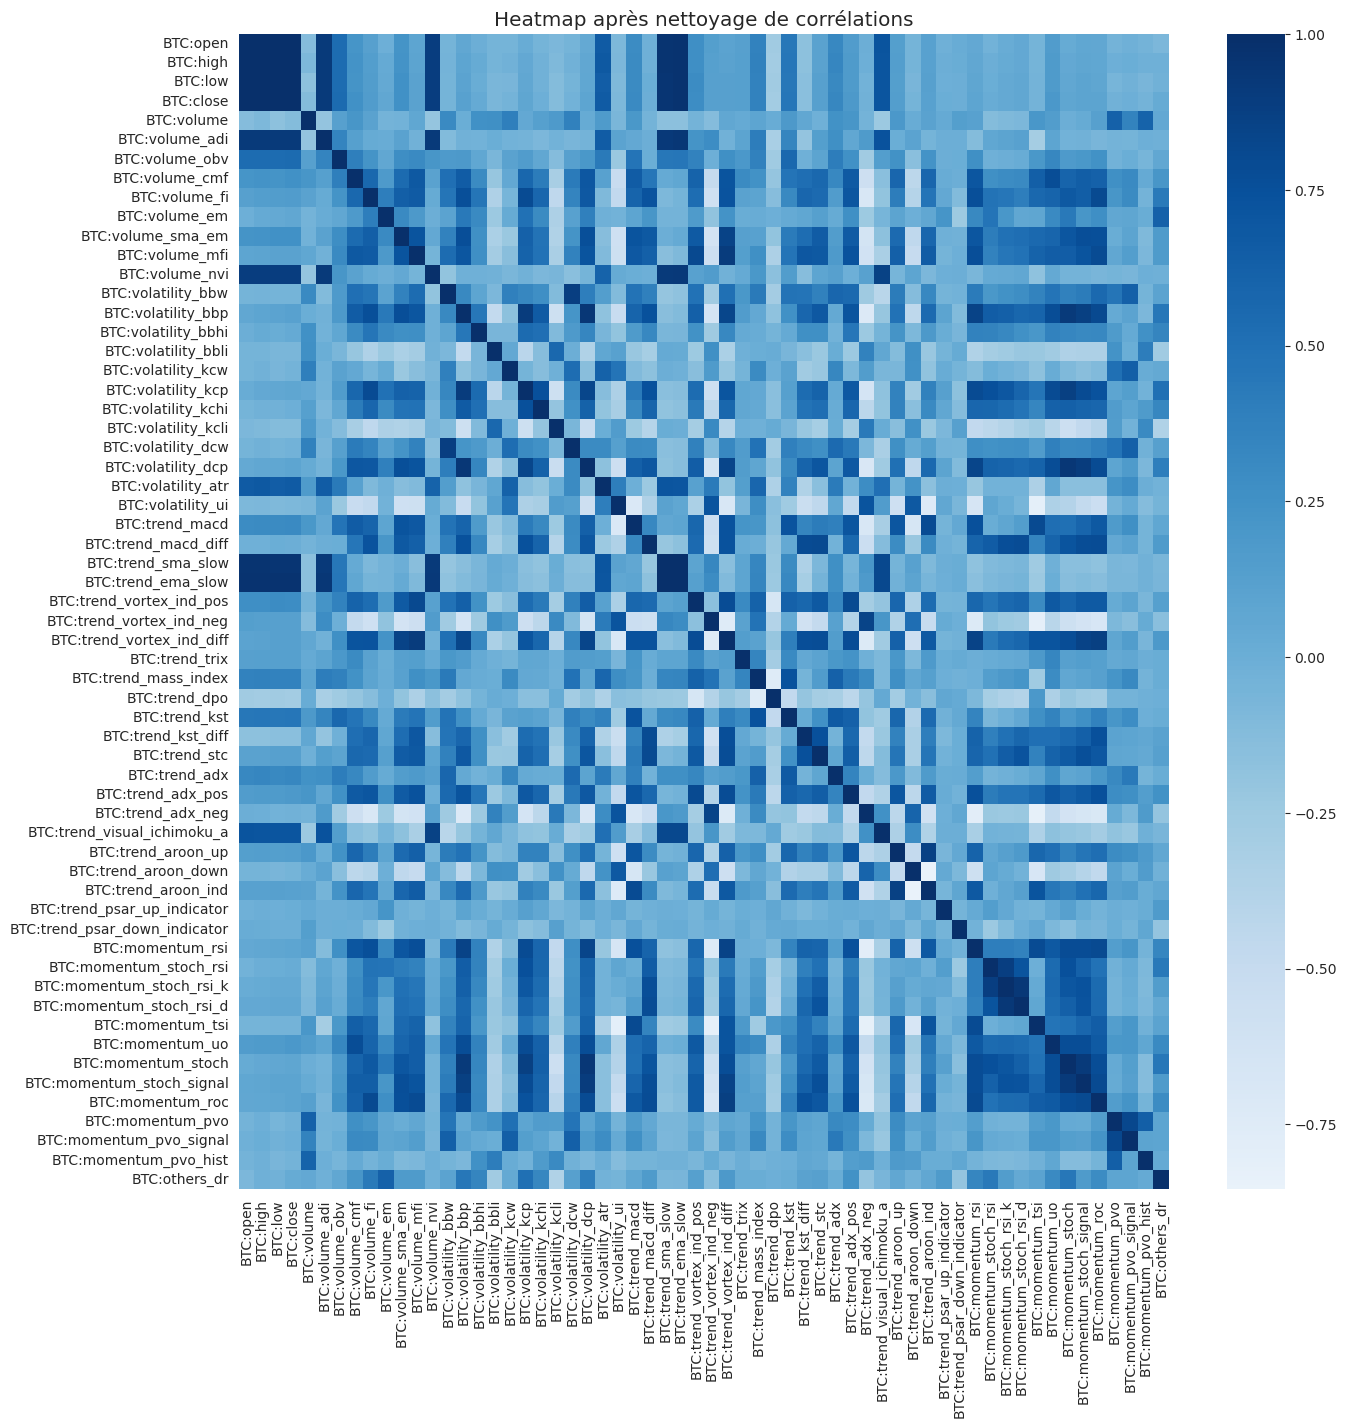

,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume,BTC:volume_adi,BTC:volume_obv,BTC:volume_cmf,BTC:volume_fi,BTC:volume_em,...,BTC:momentum_stoch_rsi_d,BTC:momentum_tsi,BTC:momentum_uo,BTC:momentum_stoch,BTC:momentum_stoch_signal,BTC:momentum_roc,BTC:momentum_pvo,BTC:momentum_pvo_signal,BTC:momentum_pvo_hist,BTC:others_dr
date,,,,,,,,,,,,,,,,,,,,,
2024-01-18,42776.09,42930.00,40683.28,41327.50,43907.51641,-18727.609504,43907.51641,-0.426524,0.000000e+00,0.000000e+00,...,0.0,0.000000,0.000000,28.673800,28.673800,0.0,0.000000,0.000000,0.000000,0.000000
2024-01-19,41327.51,42196.86,40280.00,41659.03,48342.74559,2487.251044,92250.26200,0.026962,1.602707e+07,-2.253035e+09,...,0.0,100.000000,33.121256,52.038868,40.356334,0.0,0.799817,0.159963,0.639854,0.802202
2024-01-20,41659.03,41872.56,41456.30,41696.04,15923.99493,4905.727380,108174.25693,0.045350,1.382168e+07,1.113582e+09,...,0.0,100.000000,35.345558,53.435472,44.716047,0.0,-4.649238,-0.801877,-3.847361,0.088840
2024-01-21,41696.05,41881.39,41500.98,41580.33,11730.16301,-1930.829075,96444.09392,-0.016103,1.165326e+07,8.676665e+07,...,0.0,99.213635,34.234565,49.069057,51.514465,0.0,-10.237823,-2.689066,-7.548757,-0.277508
2024-01-22,41580.32,41689.65,39431.58,39568.02,55426.19911,-50658.962486,41017.89481,-0.288934,-5.945023e+06,-4.605956e+09,...,0.0,85.579279,25.415332,3.900046,35.468192,0.0,-5.399020,-3.231057,-2.167963,-4.839572


In [56]:
import ccxt
import pandas as pd
import numpy as np
import ta
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Télécharger les données OHLCV depuis Binance
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'

ohlcv = exchange.fetch_ohlcv(symbol=symbol, timeframe=timeframe)
df_AI = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
df_AI["date"] = pd.to_datetime(df_AI["timestamp"], unit="ms")
df_AI = df_AI.drop(columns=["timestamp"])
df_AI = df_AI[["date", "open", "high", "low", "close", "volume"]]

# 2. Ajouter les indicateurs techniques
df_AI_ta = ta.add_all_ta_features(
    df_AI.copy(),
    open="open",
    high="high",
    low="low",
    close="close",
    volume="volume",
    fillna=True
)

# 3. Supprimer les colonnes trop corrélées (hors OHLC)
corr_matrix = df_AI_ta.drop(columns=["date"]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

essential_suffixes = ['open', 'high', 'low', 'close']
to_drop = []

for column in upper.columns:
    if isinstance(column, str):
        keep = any(column.lower().endswith(suffix) for suffix in essential_suffixes)
        if not keep and (upper[column] > 0.95).any():
            to_drop.append(column)

df_AI_filtered = df_AI_ta.drop(columns=to_drop)

# 4. Fixer l’index sur la date
df_AI_filtered = df_AI_filtered.set_index("date")

# 5. Renommer les colonnes avec préfixe BTC: pour compatibilité TensorTrade
base, quote = 'BTC', 'USDT'
df_AI_filtered.columns = [f"{base}:{col.lower()}" for col in df_AI_filtered.columns]

# 6. Affichage optionnel de la heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df_AI_filtered.corr(), cmap="Blues", annot=False, center=0)
plt.title("Heatmap après nettoyage de corrélations")
plt.show()

# Aperçu final
df_AI_filtered.head()


## Correlation Work

In [57]:
c1 = corr_matrix[[x for x in corr_matrix.columns if x.startswith('volume')]].drop(
                [x for x in corr_matrix.index if not x.startswith('volume')])
c1 = c1.drop(
                ['volume_nvi', 'volume_adi', 'volume_fi', 'volume_vwap',
                 'volume_cmf', 'volume_em', 'volume_sma_em', 'volume_vpt']
            ).drop(
                ['volume_nvi', 'volume_adi', 'volume_fi', 'volume_vwap',
                 'volume_cmf', 'volume_em', 'volume_sma_em', 'volume_vpt'],
            axis=1)
c1

,volume,volume_obv,volume_mfi
volume,1.000000,0.121083,0.068414
volume_obv,0.121083,1.000000,0.310745
volume_mfi,0.068414,0.310745,1.000000


In [58]:
# Liste des colonnes à retirer
to_remove = [
    'momentum_rsi', 'momentum_stoch', 'momentum_wr', 'momentum_roc',
    'momentum_ao', 'momentum_uo', 'momentum_stoch_signal', 'momentum_tsi',
    'momentum_kama', 'momentum_mfi'
]

# Supprimer seulement si elles existent dans l'index ou les colonnes
c2 = corr_matrix[[x for x in corr_matrix.columns if x.startswith('momentum')]]
c2 = c2.drop(
    [x for x in c2.index if not x.startswith('momentum')],
    axis=0
)

# Supprimer dynamiquement
existing_rows = [col for col in to_remove if col in c2.index]
existing_cols = [col for col in to_remove if col in c2.columns]

c2 = c2.drop(index=existing_rows, columns=existing_cols)


In [59]:
c3 = corr_matrix[[x for x in corr_matrix.columns if x.startswith('other')]].drop(
                [x for x in corr_matrix.index if not x.startswith('other')],axis=0)
c3
# self._dr = np.log(self._close).diff()
# self._dr *= 100

,others_dr,others_dlr,others_cr
others_dr,1.000000,0.999662,0.026514
others_dlr,0.999662,1.000000,0.027641
others_cr,0.026514,0.027641,1.000000


In [60]:
c4 = corr_matrix[[x for x in corr_matrix.columns if x.startswith('vola')]].drop(
                [x for x in corr_matrix.index if not x.startswith('vola')],axis=0)
c4 = c4.drop(
                ['volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbp',
                 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
                 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
                 'volatility_dch', 'volatility_bbw']
             ).drop(
                ['volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbp',
                 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
                 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
                 'volatility_dch', 'volatility_bbw'],
             axis=1)
c4

,volatility_bbhi,volatility_bbli,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui
volatility_bbhi,1.000000,0.066208,0.045327,0.179863,0.336044,0.065770,0.193305
volatility_bbli,0.066208,1.000000,0.004709,0.003813,0.362323,0.070783,0.115502
volatility_dcm,0.045327,0.004709,1.000000,0.137257,0.134047,0.699429,0.045228
volatility_dcw,0.179863,0.003813,0.137257,1.000000,0.298543,0.298933,0.126337
volatility_dcp,0.336044,0.362323,0.134047,0.298543,1.000000,0.169067,0.557283
volatility_atr,0.065770,0.070783,0.699429,0.298933,0.169067,1.000000,0.403151
volatility_ui,0.193305,0.115502,0.045228,0.126337,0.557283,0.403151,1.000000


In [61]:
c5 = corr_matrix[[x for x in corr_matrix.columns if x.startswith('trend')]].drop(
                [x for x in corr_matrix.index if not x.startswith('trend')],axis=0)
c5 = c5.drop(
                ['trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
                 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
                 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
                 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst', 'trend_kst_sig',
                 'trend_kst_diff', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b',
                 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
                 'trend_psar_down', 'trend_psar_up_indicator', 'trend_psar_down_indicator',
                 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a',
                 'trend_ichimoku_b', 'trend_macd_diff']
             ).drop(
                ['trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
                 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
                 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
                 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst', 'trend_kst_sig',
                 'trend_kst_diff', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b',
                 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
                 'trend_psar_down', 'trend_psar_up_indicator', 'trend_psar_down_indicator',
                 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a',
                 'trend_ichimoku_b', 'trend_macd_diff'],
             axis=1)
c5
# trend_macd > 0
# and trend_macd_signal > 0
# and trend_macd_signal > trend_macd

,trend_macd,trend_macd_signal,trend_stc
trend_macd,1.000000,0.962253,0.417563
trend_macd_signal,0.962253,1.000000,0.209220
trend_stc,0.417563,0.209220,1.000000


In [62]:
# 1. Regrouper toutes les colonnes depuis les DataFrames c1, c2, c4, c5
frames = [c1, c2, c4, c5]
d = list({col for df_ in frames for col in df_.columns})

# 2. Ne garder que les colonnes présentes dans df
d = [col for col in d if col in df.columns]

# 3. Calculer la matrice de corrélation absolue
corr_matrix = df[d].corr().abs()

# 4. Afficher la matrice (optionnel)
corr_matrix


,volatility_dcp,trend_macd,volatility_bbhi,momentum_ppo,momentum_pvo,volatility_atr,trend_stc,momentum_pvo_hist,momentum_ppo_hist,volume_mfi,...,momentum_stoch_rsi_k,volatility_dcm,trend_macd_signal,momentum_ppo_signal,momentum_stoch_rsi,momentum_stoch_rsi_d,volatility_dcw,volatility_ui,volatility_bbli,volume_obv
volatility_dcp,1.000000,0.640876,0.342995,0.654160,0.101298,0.210342,0.726795,0.104040,0.673931,0.739060,...,0.603388,0.141119,0.473073,0.480339,0.608992,0.570957,0.310589,0.591738,0.368168,0.218150
trend_macd,0.640876,1.000000,0.172324,0.971412,0.168876,0.049134,0.399023,0.062388,0.251051,0.713449,...,0.058872,0.117506,0.962749,0.945049,0.009135,0.115054,0.292328,0.767214,0.221900,0.481675
volatility_bbhi,0.342995,0.172324,1.000000,0.189422,0.171250,0.065770,0.224927,0.218942,0.317622,0.269205,...,0.290065,0.071064,0.091520,0.102604,0.335652,0.213694,0.171894,0.212485,0.066067,0.070097
momentum_ppo,0.654160,0.971412,0.189422,1.000000,0.206260,0.090197,0.430192,0.049939,0.285320,0.770591,...,0.068575,0.002801,0.928552,0.961630,0.001265,0.122681,0.351460,0.771222,0.220816,0.470004
momentum_pvo,0.101298,0.168876,0.171250,0.206260,1.000000,0.214893,0.011642,0.631987,0.007223,0.066774,...,0.053912,0.117326,0.160328,0.202447,0.026808,0.070303,0.474230,0.069318,0.233177,0.071034
volatility_atr,0.210342,0.049134,0.065770,0.090197,0.214893,1.000000,0.202171,0.004943,0.237614,0.231930,...,0.125270,0.649972,0.032678,0.011722,0.101558,0.140069,0.202618,0.339534,0.070783,0.428423
trend_stc,0.726795,0.399023,0.224927,0.430192,0.011642,0.202171,1.000000,0.024821,0.820467,0.668015,...,0.649176,0.028066,0.181252,0.195566,0.489966,0.731794,0.143117,0.482857,0.240735,0.006934
momentum_pvo_hist,0.104040,0.062388,0.218942,0.049939,0.631987,0.004943,0.024821,1.000000,0.058236,0.136374,...,0.136686,0.017886,0.047912,0.035431,0.123391,0.126737,0.060778,0.126939,0.419326,0.086544
momentum_ppo_hist,0.673931,0.251051,0.317622,0.285320,0.007223,0.237614,0.820467,0.058236,1.000000,0.592463,...,0.790853,0.127893,0.014664,0.011426,0.666921,0.820774,0.237917,0.322413,0.291181,0.017061
volume_mfi,0.739060,0.713449,0.269205,0.770591,0.066774,0.231930,0.668015,0.136374,0.592463,1.000000,...,0.400841,0.158762,0.579138,0.628308,0.317114,0.440036,0.336270,0.671182,0.307200,0.268423


In [63]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

upper[[x for x in upper.columns if any(upper[x] > 0.5)]]

,trend_macd,momentum_ppo,trend_stc,momentum_pvo_hist,momentum_ppo_hist,volume_mfi,momentum_pvo_signal,momentum_stoch_rsi_k,volatility_dcm,trend_macd_signal,momentum_ppo_signal,momentum_stoch_rsi,momentum_stoch_rsi_d,volatility_dcw,volatility_ui,volume_obv
volatility_dcp,0.640876,0.654160,0.726795,0.104040,0.673931,0.739060,0.190019,0.603388,0.141119,0.473073,0.480339,0.608992,0.570957,0.310589,0.591738,0.218150
trend_macd,NaN,0.971412,0.399023,0.062388,0.251051,0.713449,0.255119,0.058872,0.117506,0.962749,0.945049,0.009135,0.115054,0.292328,0.767214,0.481675
volatility_bbhi,NaN,0.189422,0.224927,0.218942,0.317622,0.269205,0.055544,0.290065,0.071064,0.091520,0.102604,0.335652,0.213694,0.171894,0.212485,0.070097
momentum_ppo,NaN,NaN,0.430192,0.049939,0.285320,0.770591,0.288132,0.068575,0.002801,0.928552,0.961630,0.001265,0.122681,0.351460,0.771222,0.470004
momentum_pvo,NaN,NaN,0.011642,0.631987,0.007223,0.066774,0.827603,0.053912,0.117326,0.160328,0.202447,0.026808,0.070303,0.474230,0.069318,0.071034
volatility_atr,NaN,NaN,0.202171,0.004943,0.237614,0.231930,0.312620,0.125270,0.649972,0.032678,0.011722,0.101558,0.140069,0.202618,0.339534,0.428423
trend_stc,NaN,NaN,NaN,0.024821,0.820467,0.668015,0.033715,0.649176,0.028066,0.181252,0.195566,0.489966,0.731794,0.143117,0.482857,0.006934
momentum_pvo_hist,NaN,NaN,NaN,NaN,0.058236,0.136374,0.088028,0.136686,0.017886,0.047912,0.035431,0.123391,0.126737,0.060778,0.126939,0.086544
momentum_ppo_hist,NaN,NaN,NaN,NaN,NaN,0.592463,0.051464,0.790853,0.127893,0.014664,0.011426,0.666921,0.820774,0.237917,0.322413,0.017061
volume_mfi,NaN,NaN,NaN,NaN,NaN,NaN,0.155516,0.400841,0.158762,0.579138,0.628308,0.317114,0.440036,0.336270,0.671182,0.268423


## Enable Plotly Chart

In [64]:
import tensortrade as tt
print(tt.__version__)
print(dir(tt.env))  # voir si 'default' existe



1.0.3
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'default', 'generic']


In [65]:
import tensortrade.env.default as default
print(dir(default))



['AggregateRenderer', 'DataFeed', 'Portfolio', 'TradingEnv', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'actions', 'create', 'informers', 'observers', 'renderers', 'rewards', 'stoppers']


In [66]:
#pip uninstall tensortrade -y
#pip install git+https://github.com/kodiakcrypto/tensortrade.git#egg=tensortrade[data,render]


In [67]:
#!pip uninstall tensortrade -y
#!pip install tensortrade -y



##Optuna

In [68]:
#!pip install optuna==1.2.0 # DB was created in 1.2, 1.4 dont like that
import optuna

In [69]:
from tensortrade.agents import DQNAgent
from tensortrade.feed.core.renderers import PlotlyTradingChart

chart_renderer = PlotlyTradingChart()


def Train_DQN_Agent():
    n_episodes =  10000
    window_size = 1
    learning_rate = 0.001
    discount_factor = 0.9999

    # Random slice of data for training
    # start_bound = len(df['close']) / 100
    # start_slice = 0

    # end_bound_2 = start_slice + 100#len(df['BTC:close'])
    # end_bound_1 = start_slice + window_size * 2
    # if end_bound_1 >= end_bound_2:
    #     end_bound_1 = end_bound_2 - window_size
    # end_slice = start_slice + 100


    batch_size = 128
    memory_capacity = 1000
    eps_start = 0.9
    eps_end = 0.05
    eps_decay_steps = 200

    save_path = "./agents/"
    n_steps = len(df['close']-1)#end_slice - start_slice + 1 .iloc[start_slice:end_slice]
    render_interval = 1
    # print('steps', end_slice - start_slice)

    save_every = 500
    update_target_every = 1000

    print(df.columns)
    streams = [Stream(name, list(df[name])) for name in df.columns]
    feed = DataFeed(streams)
    print(repr(feed))


    exchange = Exchange("TEST1", service=execute_order)(
            Stream("USD-BTC", list(df['close']))
    )
    portfolio = Portfolio(USD, [
        Wallet(exchange, 1000000 * USD),
        Wallet(exchange, 0 * BTC)
    ])

    from tensortrade.env.default import create

    env = create(
        feed=feed,
        portfolio=portfolio,
        action_scheme='simple',
        reward_scheme='simple',
        window_size=window_size,
        renderers=[chart_renderer, 'screenlog']
    )

    print(env)

    agent = DQNAgent(env)

    mean_reward = agent.train(
        n_steps = n_steps,
        n_episodes = n_episodes,
        learning_rate = learning_rate,
        save_path = save_path,

        batch_size = batch_size,
        discount_factor = discount_factor,

        #save_every = save_every,
        update_target_every = update_target_every,
        memory_capacity = memory_capacity,
        render_interval = render_interval,

        eps_start = eps_start,
        eps_end = eps_end,
        eps_decay_steps = eps_decay_steps
    )

    chart_renderer.fig.show()

    return mean_reward

Train_DQN_Agent()

ModuleNotFoundError: No module named 'tensortrade.feed.core.renderers'

In [ ]:

    from tensortrade.actions import ManagedRiskOrders
    # action_scheme = ManagedRiskOrders(
    #     #durations=[6],
    #     stop_loss_percentages=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
    #                            0.005, 0.0075, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065],
    #     take_profit_percentages=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
    #                            0.005, 0.0075, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065],
    #     trade_sizes = [1/30, 1/25, 1/20, 1/15])
    # """
    # Args:
    #     pairs: A list of trading pairs to select from when submitting an order.
    #            e.g. TradingPair(BTC, USD)
    #     stop_loss_percentages: A list of possible stop loss percentages for each order.
    #     take_profit_percentages: A list of possible take profit percentages for each order.
    #     trade_sizes: A list of trade sizes to select from when submitting an order.
    #                  e.g. '[1, 1/3]' = 100% or 33% of balance is tradable.
    #                       '4' = 25%, 50%, 75%, or 100% of balance is tradable.

    #     order_listener (optional): An optional listener for order events executed by this action scheme.
    # """

    # from tensortrade.rewards import RiskAdjustedReturns
    # reward_scheme = RiskAdjustedReturns(
    #     return_algorithm='sortino',
    #     minimize_trades = True,
    #     window_size = window_size
    #     )
    # """
    #     Args:
    #         return_algorithm (optional): The risk-adjusted return metric to use.
    #                                      Options are 'sharpe' and 'sortino'. Defaults to 'sharpe'.
    #         risk_free_rate (optional): The risk free rate of returns to use for calculating metrics.
    #                                    Defaults to 0.
    #         target_returns (optional): The target returns per period for use in calculating the
    #                                    sortino ratio. Default to 0.
    # """


### Train DQN Agent with Optuna

In [ ]:
from tensortrade.agents import DQNAgent

def Train_DQN_Agent(trial):

    # OPTUNA PARAMETER TYPES
    # optimizer = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam'])
    # num_layers = trial.suggest_int('num_layers', 1, 3)
    # dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 1.0)
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    # drop_path_rate = trial.suggest_discrete_uniform('drop_path_rate', 0.0, 1.0, 0.1) #0.1 increments

    #set optunable vars
    #n_steps = trial.suggest_int('n_steps', 16, 100)
    n_episodes = trial.suggest_int('n_episodes', 1000, 10000)
    window_size = trial.suggest_int('window_size', 2, 100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.00)
    discount_factor = trial.suggest_uniform('discount_factor', 0.5000, 0.9999)

    # Random slice of data for training
    start_bound = len(df['close']) / 100
    start_slice = trial.suggest_int('start_slice', 0, start_bound)

    end_bound_2 = start_slice + 100#len(df['BTC:close'])
    end_bound_1 = start_slice + window_size * 2
    if end_bound_1 >= end_bound_2:
        end_bound_1 = end_bound_2 - window_size
    end_slice = trial.suggest_int('end_slice', end_bound_1, end_bound_2)


    batch_size = 128
    memory_capacity = 1000
    eps_start = 0.9
    eps_end = 0.05
    eps_decay_steps = 200
    save_path = "agents/"
    n_steps = end_slice - start_slice + 1
    render_interval = 10#int(n_steps / 5)
    print('steps', end_slice - start_slice)
    #save_every = int(n_episodes / 10)
    update_target_every = 1000


    with Module("coinbase") as coinbase_ns:
        nodes = [Stream(name, list(df[name][start_slice:end_slice])) for name in df.columns]

    feed = DataFeed([coinbase_ns])

    exchange = Exchange("coinbase", service=execute_order)(
            Stream("USD-BTC", list(df['close'][start_slice:end_slice]))
    )
    portfolio_list.append(Portfolio(USD, [
        Wallet(exchange, 1000000 * USD),
        Wallet(exchange, 0 * BTC)
    ]))


    from tensortrade.actions import ManagedRiskOrders
    action_scheme = ManagedRiskOrders(
        #durations=[6],
        stop_loss_percentages=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                               0.005, 0.0075, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065],
        take_profit_percentages=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                               0.005, 0.0075, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065],
        trade_sizes = [1/30, 1/25, 1/20, 1/15])
    """
    Args:
        pairs: A list of trading pairs to select from when submitting an order.
               e.g. TradingPair(BTC, USD)
        stop_loss_percentages: A list of possible stop loss percentages for each order.
        take_profit_percentages: A list of possible take profit percentages for each order.
        trade_sizes: A list of trade sizes to select from when submitting an order.
                     e.g. '[1, 1/3]' = 100% or 33% of balance is tradable.
                          '4' = 25%, 50%, 75%, or 100% of balance is tradable.

        order_listener (optional): An optional listener for order events executed by this action scheme.
    """

    from tensortrade.rewards import RiskAdjustedReturns
    reward_scheme = RiskAdjustedReturns(
        return_algorithm='sortino',
        minimize_trades = True,
        window_size = window_size
        )
    """
        Args:
            return_algorithm (optional): The risk-adjusted return metric to use.
                                         Options are 'sharpe' and 'sortino'. Defaults to 'sharpe'.
            risk_free_rate (optional): The risk free rate of returns to use for calculating metrics.
                                       Defaults to 0.
            target_returns (optional): The target returns per period for use in calculating the
                                       sortino ratio. Default to 0.
    """


    env = TradingEnvironment(
        feed = feed,
        portfolio = portfolio_list[-1],
        action_scheme = action_scheme,
        window_size = window_size,
        reward_scheme = reward_scheme,
        # enable_logger = True,
        renderers = [chart_renderer, 'screenlog'],
        price_history = ohlcv_df
    )
    env_list.append(env)

    agent = DQNAgent(env_list[-1])

    mean_reward = agent.train(
        n_steps = n_steps,
        n_episodes = n_episodes,
        learning_rate = learning_rate,
        save_path = save_path,

        batch_size = batch_size,
        discount_factor = discount_factor,

        #save_every = save_every,
        update_target_every = update_target_every,
        memory_capacity = memory_capacity,
        render_interval = render_interval,

        eps_start = eps_start,
        eps_end = eps_end,
        eps_decay_steps = eps_decay_steps
    )

    chart_renderer.fig.show()

    return mean_reward

### Shap - WORK IN PROGRESS

In [ ]:
!pip install shap
import shap

In [ ]:
from tensortrade.agents import DQNAgent
from tensortrade.actions import ManagedRiskOrders
from tensortrade.rewards import RiskAdjustedReturns

import tensorflow as tf


with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, list(df['BTC:close'])) for name in df.columns]

feed = DataFeed([coinbase_ns])

exchange = Exchange("coinbase", service=execute_order)(
        Stream("USD-BTC", list(df['BTC:close']))
)

portfolio = Portfolio(USD, [
    Wallet(exchange, 1000000 * USD),
    Wallet(exchange, 0 * BTC)
])

action_scheme = ManagedRiskOrders(
    stop_loss_percentages=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                            0.005, 0.0075, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065],
    take_profit_percentages=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                            0.005, 0.0075, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065],
    trade_sizes = [1/30, 1/25, 1/20, 1/15])

reward_scheme = RiskAdjustedReturns(
    return_algorithm='sortino',
    minimize_trades = True,
    window_size = 48
    )

env = TradingEnvironment(
    feed = feed,
    portfolio = portfolio,
    action_scheme = action_scheme,
    window_size = 48,
    reward_scheme = reward_scheme,
)

policy_network = None
try:
  policy_network = tf.keras.models.load_model(
      'agents/policy_network__4f977c8a-aefe-46db-9df1-15444dae5418__465.hdf5'
  )
except Exception as e:
  print(e)

agent = DQNAgent(env, policy_network=policy_network)

background = np.resize(np.array(df[['BTC:close']].sample(n=100)), (100, 1, 0))
print(background.shape)

In [ ]:
e = shap.DeepExplainer(agent.policy_network, background)
shap_values = e.shap_values(data[1:5])

In [ ]:
shap.image_plot(shap_values, -data[1:5])

###Run Optuna Trials
- each trial trains a network
- then at the end it tells us what one did best

In [ ]:
# Initiate Optuna trials
env_list = []
portfolio_list = []
n_trials = 1

# example callback (unused but passes out the 'portfolio'
# callbacks = [
#     lambda study_, frozen_trial_ : portfolio_chart(study_, frozen_trial_, portfolio)
# ]

study_name = 'new_921'

study = optuna.create_study(study_name=study_name,
                            storage=f'sqlite:///{study_name}.db',
                            load_if_exists=True,
                            direction='maximize')

study.optimize(Train_DQN_Agent,
               n_trials=n_trials)
               #callbacks=callbacks)

### Print results

In [ ]:
study.trials

In [ ]:
study.best_trial

In [ ]:
study.best_params

In [ ]:
study.best_value

In [ ]:
for portfolio in portfolio_list:
    portfolio.performance.plot(legend='reverse')

In [ ]:
for portfolio in portfolio_list:
    portfolio.performance.net_worth.plot()

In [ ]:
study_name = '1h_bb_macd_atr_obv_7'
study = optuna.load_study(study_name=study_name,
                          storage=f'sqlite:///{study_name}.db')

#Show all trials in DB
df = study.trials_dataframe(attrs=('value', 'params'))
df2 = pd.concat([df['value'],
                 df['params_learning_rate'],
                 df['params_n_episodes'],
                 df['params_window_size']
                 ],
                axis=1)
df2 = df2.sort_values('value', ascending=True)
print(df2.tail(20))

### Delete SQL entries for incomplete trials

In [ ]:
import sqlite3
con = sqlite3.connect(f'{study_name}.db')
cursor = con.cursor()

cursor.execute("SELECT * FROM trials") #show all values in trials table
print(cursor.fetchall())

cursor.execute("DELETE from trials WHERE value is null")
cursor.execute("SELECT value FROM trials") #prove u removed the None values
print(cursor.fetchall())

con.commit() #save changes
cursor.close() #close connecton